In [59]:
import torch

a = "/home/s2765918/code-et/results/HRC/test_nofinetune_9/models/test_nofinetune_9_fold_1.pt"

In [60]:
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
import matplotlib.pyplot as plt

In [61]:
transform = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [62]:
import cv2
img = torch.Tensor(cv2.imread("/home/s2765918/code-et/code/cctv_image.jpeg"))

In [63]:
model = model.module.to("cpu")

AttributeError: 'ensemble' object has no attribute 'module'

In [ ]:
model(img)

In [ ]:
model = torch.load(a,map_location="cpu")

In [ ]:
model.module.model_2

In [ ]:
model.module.model_2.vit_model.encoder.layers.encoder_layer_0.self_attention.out_proj.weight.size()

torch.Size([768, 768])

In [ ]:
model.module.model_2.vit_model.encoder.layers.encoder_layer_0.self_attention

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)

In [ ]:
from trajectory import Trajectory, TrajectoryDataset, extract_fixed_sized_segments, split_into_train_and_test, remove_short_trajectories, get_categories, get_UTK_categories, get_NTU_categories
import pickle
from einops import rearrange, repeat


In [ ]:


#Load test trajectories
PIK = "/home/s2765918/code-et/code/data/HRC/trajectories_train_HRC_2D.dat"

with open(PIK, "rb") as f:
    trajectories = pickle.load(f)

In [ ]:
train_crime_trajectories = remove_short_trajectories(trajectories, input_length=20, input_gap=0, pred_length=0)

In [ ]:
dataset = TrajectoryDataset(*extract_fixed_sized_segments("HRC", train_crime_trajectories, input_length=20))

In [68]:

img = dataset[12509]["extracted_frames"]
img = rearrange(img,"c h w -> h w c")

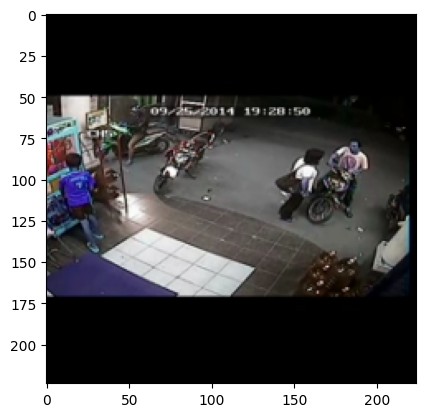

In [69]:
plt.imshow(img)

In [ ]:
input = torch.tensor(dataset[159]["coordinates"])

In [ ]:
result = model(input.unsqueeze(0),dataset[159]["extracted_frames"].unsqueeze(0))

RuntimeError: module must have its parameters and buffers on device cuda:0 (device_ids[0]) but found one of them on device: cpu

In [ ]:
result.

In [ ]:
model.model_2.vit_model.encoder.layers.encoder_layer_4.self_attention.q_proj_weight

In [67]:
torch.argmax(model(torch.Tensor(dataset[12509]["coordinates"]).unsqueeze(0),dataset[12509]["extracted_frames"].unsqueeze(0)))

tensor(11)

In [65]:
dataset[12509]["categories"]

array([11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 11, 11])

In [76]:
import cv2
import glob
import os
# images = [cv2.imread(image, 0) for image in glob.glob("*.png")]

# result = cv2.bitwise_and(images[0], images[1])
# for image in images[2:]:
#     result = cv2.bitwise_and(result, image)

# cv2.imshow('result', result)
# cv2.waitKey(0)

In [70]:
path="/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos"

In [73]:
ids = dataset[12509]["id"]

In [77]:
getVideoFiles = ids[0]

videoDir =  getVideoFiles.split("_")[0][:-3] 

videofile = getVideoFiles.split("_")[0]+"_x264.mp4"

video_path = os.path.join(path,videoDir,videofile)

In [78]:
print(video_path)

/deepstore/datasets/dmb/MachineLearning/HRC/HRC_files/UCF_Videos/Stealing/Stealing025_x264.mp4
